In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

from dm_tools import analyse_feature_importance

import pickle

In [2]:
patients = pd.read_excel('dataset.xlsx')

In [3]:
target = ['SARS-Cov-2 exam result']
features =  ['Patient age quantile', 'Proteina C reativa mg/dL', 'Neutrophils', 'Mean platelet volume ', 'Monocytes',
             'Red blood cell distribution width (RDW)', 'Red blood Cells', 'Platelets', 'Eosinophils', 'Basophils',
             'Leukocytes', 'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)',
             'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Lymphocytes', 'Hemoglobin', 'Hematocrit',
             'Influenza B, rapid test', 'Influenza A, rapid test']
all_covariates = target + features

# Limit the dataframe to only the target and features we are interested in
patients = patients[all_covariates]

# Drop patients that haven't had a FBC
patients = patients.dropna(subset=['Leukocytes'])

# Onehot the categoricals
patients['SARS-Cov-2 exam result'] = patients['SARS-Cov-2 exam result'].map({'negative':0, 'positive':1})
patients['Influenza B, rapid test'] = patients['Influenza B, rapid test'].map({'negative':0, 'positive':1})
patients['Influenza A, rapid test'] = patients['Influenza A, rapid test'].map({'negative':0, 'positive':1})

# Impute residual missing data
patients['Proteina C reativa mg/dL'].fillna(np.mean(patients['Proteina C reativa mg/dL']), inplace=True)
patients['Monocytes'].fillna(np.mean(patients['Monocytes']), inplace=True)
patients['Mean platelet volume '].fillna(np.mean(patients['Mean platelet volume ']), inplace=True)
patients['Neutrophils'].fillna(np.mean(patients['Neutrophils']), inplace=True)

patients['Influenza B, rapid test'].fillna(0, inplace=True)
patients['Influenza A, rapid test'].fillna(0, inplace=True)

y = patients['SARS-Cov-2 exam result']
X = patients.drop(['SARS-Cov-2 exam result'], axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
rs=42

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, stratify=y, random_state=rs)

### Regression Model - Default

In [5]:
from sklearn.preprocessing import StandardScaler

# initialise a standard scaler object
scaler = StandardScaler()

# visualise min, max, mean and standard dev of data before scaling
print("Before scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# learn the mean and std.dev of variables from training data
# then use the learned values to transform training data
X_train = scaler.fit_transform(X_train, y_train)

print("After scaling\n-------------")
for i in range(5):
    col = X_train[:,i]
    print("Variable #{}: min {}, max {}, mean {:.2f} and std dev {:.2f}".
          format(i, min(col), max(col), np.mean(col), np.std(col)))

# use the statistic that you learned from training to transform test data
X_test = scaler.transform(X_test)

Before scaling
-------------
Variable #0: min -1.9552032701632158, max 1.3746977131790805, mean 0.00 and std dev 0.97
Variable #1: min -0.5880682765973898, max 8.758105835102347, mean -0.01 and std dev 0.97
Variable #2: min -3.1118960195323258, max 2.747114031836903, mean 0.02 and std dev 0.99
Variable #3: min -2.0138258156348536, max 2.7100744597001416, mean -0.02 and std dev 0.96
Variable #4: min -2.16552067844443, max 4.537167190820846, mean -0.01 and std dev 1.00
After scaling
-------------
Variable #0: min -2.0187491392926256, max 1.411151957819038, mean -0.00 and std dev 1.00
Variable #1: min -0.589477386855145, max 9.009862503946579, mean 0.00 and std dev 1.00
Variable #2: min -3.1649310224828144, max 2.761239564394047, mean -0.00 and std dev 1.00
Variable #3: min -2.083985159002029, max 2.8590016364088546, mean -0.00 and std dev 1.00
Variable #4: min -2.1536712263709803, max 4.549471469936996, mean 0.00 and std dev 1.00


In [6]:
from sklearn import set_config

set_config(print_changed_only = False)

#initiate a model object (with random state to ensure consistent result) and fit it to the training dataset.
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [7]:
#initiate a model object (with random state to ensure consistent result) and fit it to the training dataset.
model = LogisticRegression(random_state=rs)

# fit it to training data
model.fit(X_train, y_train)

# training and test accuracy
print("Train accuracy:", model.score(X_train, y_train))
print("Test accuracy:", model.score(X_test, y_test))

# classification report on test data
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

Train accuracy: 0.8954869358669834
Test accuracy: 0.8784530386740331
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       156
           1       0.57      0.48      0.52        25

    accuracy                           0.88       181
   macro avg       0.75      0.71      0.73       181
weighted avg       0.87      0.88      0.87       181



While the model has a high accuracy score on training data, the training accuracy is slightly higher than the test accuracy which indicates slight overfitting. We will tune this logistic regression model later using GridSearchCV to imrprove the accuracy.

### looking at the coefficients

In [8]:
print(model.coef_)

[[ 0.31618188  0.28380143 -0.37353104  0.17618039  0.20502125 -0.10675624
   0.18710568 -0.58659553 -1.21781813 -0.14706076 -1.78419268 -0.14269664
  -0.03340144 -0.28872933 -0.30504017  0.25066558  0.4379507  -0.6344502
  -0.42278115]]


In [31]:
# grab feature importances from the model and feature name from the original X
coef = model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

# limit to 5 features
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', coef[i])
print()
#calculate odds ratio
for i in indices:
    print(feature_names[i], ': OR ', np.exp(coef[i]))

Leukocytes : -1.7841926840206466
Eosinophils : -1.2178181328761097
Influenza B, rapid test : -0.6344501968278315
Platelets : -0.5865955337728928
Hematocrit : 0.43795069532977676

Leukocytes : OR  0.1679325809451679
Eosinophils : OR  0.2958750231586932
Influenza B, rapid test : OR  0.5302269286401556
Platelets : OR  0.5562176893375862
Hematocrit : OR  1.5495285065440476


Top 5 most important variables are Leukocytes, Eosinophils, Influenza B Rapid Test, Platelets, and Hematocrits

### Grid search model

In [10]:
# grid search CV  range from  10^−6  to  10^4
params = {'C': [pow(10, x) for x in range(-6, 4)]}

# use all cores to tune logistic regression with C parameter
cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs),return_train_score=True, cv=10, n_jobs=-1)
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=42, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             n_jobs=-1,
             param_grid={'C': [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [11]:
result_set = cv.cv_results_
print(result_set)

{'mean_fit_time': array([0.00680065, 0.00750055, 0.00700109, 0.00470011, 0.00459993,
       0.00610051, 0.00850048, 0.01680143, 0.02450266, 0.0223006 ]), 'std_fit_time': array([0.00140039, 0.00206116, 0.00141418, 0.00126857, 0.00128091,
       0.00113618, 0.00128439, 0.00107712, 0.00215746, 0.00134516]), 'mean_score_time': array([0.00069978, 0.00049996, 0.00029986, 0.00050025, 0.00080049,
       0.00029998, 0.00020013, 0.00030012, 0.00040002, 0.00030007]), 'std_score_time': array([0.00064004, 0.00049996, 0.00045804, 0.00050025, 0.0006001 ,
       0.00045822, 0.00040026, 0.00045844, 0.00066325, 0.00045837]), 'param_C': masked_array(data=[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                   1000],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 1e-06}, {'C': 1e-05}, {'C': 0.0001}, {'C': 0.001}, {'C': 0.01}, {'C': 0.1}, {'C': 1}, {'C': 10}, {'C'

C is the only hyperparameter that is fine-tuned in Regression model

Total number of models:  10


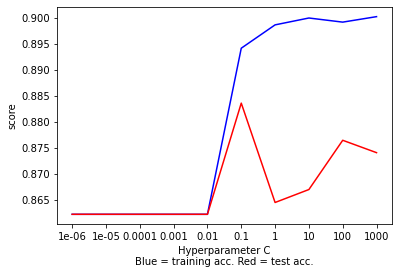

In [12]:
# train and test score of all splits
train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']
print("Total number of models: ", len(test_result))
# plot Hyperparameter C values vs training and test accuracy score
plt.plot(range(0, len(train_result)), train_result, 'b', range(0,len(test_result)), test_result, 'r')
plt.xlabel('Hyperparameter C\nBlue = training acc. Red = test acc.')
plt.xticks(range(0, len(train_result)),[pow(10, x) for x in range(-6, 4)])
plt.ylabel('score')
plt.show()

This figure ascertains that setting C > 0.1 causes the model to be overfiting (the test error beyond this point degrades regrardless of slight improvement in training accuracy error). The test accuracy does increase at C = 100 but the score is still below that of when C = 0.1

C = 0.1 provides the best test score and so it is selected as the optimal value.

In [13]:
print(cv.best_params_)

{'C': 0.1}


In [14]:
cv.fit(X_train, y_train)

print("Train accuracy:", cv.score(X_train, y_train))
print("Test accuracy:", cv.score(X_test, y_test))

Train accuracy: 0.8931116389548693
Test accuracy: 0.8674033149171271


The default settings actually had a slightly better test accuracy than the model tuned with GridSearchCV.

Logistic regression has been chosen as the regression method as it is a classification issue. This is because we are trying to identify whether or not a patient will have a positive COVID-19 result. The target variable is a categorical variable which only indicates postive or negative COVID-19 tests. Therefore, the regression function used is LogisticRegression from the package sklearn.linear_model.
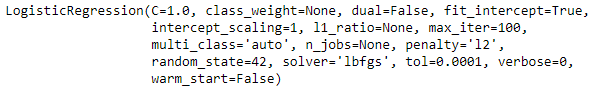

Standardisation was performed on the variables in the form of scaling the variable ranges using the function StandardScaler from the package sklearn.preprocessing. <brief reason as to why it is used>.



In [15]:
print(target)
print(features)

['SARS-Cov-2 exam result']
['Patient age quantile', 'Proteina C reativa mg/dL', 'Neutrophils', 'Mean platelet volume ', 'Monocytes', 'Red blood cell distribution width (RDW)', 'Red blood Cells', 'Platelets', 'Eosinophils', 'Basophils', 'Leukocytes', 'Mean corpuscular hemoglobin (MCH)', 'Mean corpuscular volume (MCV)', 'Mean corpuscular hemoglobin concentration\xa0(MCHC)', 'Lymphocytes', 'Hemoglobin', 'Hematocrit', 'Influenza B, rapid test', 'Influenza A, rapid test']


Top 5 most important variables are Leukocytes, Eosinophils, Influenza B Rapid Test, Platelets, and Hematocrits

default:
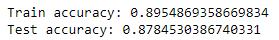

GridSearchCV:
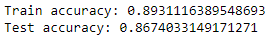

The training accuracy is slightly higher than the test accuracy which indicates slight overfitting.

### Recursive Feature Elimination

One way is to reduce the size of input set expecting that it will improve model performance, reduce overfitting and enhance visualiation.

In [16]:
from sklearn.feature_selection import RFECV

rfe = RFECV(estimator = LogisticRegression(random_state=rs), cv=10)
rfe.fit(X_train, y_train) # run the RFECV

# comparing how many variables before and after
print("Original feature set", X_train.shape[1])
print("Number of features after elimination", rfe.n_features_)

Original feature set 19
Number of features after elimination 5


In [17]:
print(rfe)

RFECV(cv=10,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=100,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=42,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      importance_getter='auto', min_features_to_select=1, n_jobs=None,
      scoring=None, step=1, verbose=0)


In [18]:
X_train_sel = rfe.transform(X_train)
X_test_sel = rfe.transform(X_test)

In [19]:
# grid search CV
params = {'C': [pow(10, x) for x in range(-6, 4)]}

rfe_cv = GridSearchCV(param_grid=params, estimator=LogisticRegression(random_state=rs), cv=10, n_jobs=-1)
rfe_cv.fit(X_train_sel, y_train)

# test the best model
print("Train accuracy:", rfe_cv.score(X_train_sel, y_train))
print("Test accuracy:", rfe_cv.score(X_test_sel, y_test))

y_pred = rfe_cv.predict(X_test_sel)
print(classification_report(y_test, y_pred))

# print parameters of the best model
print(rfe_cv.best_params_)

Train accuracy: 0.8836104513064132
Test accuracy: 0.850828729281768
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       156
           1       0.38      0.12      0.18        25

    accuracy                           0.85       181
   macro avg       0.62      0.54      0.55       181
weighted avg       0.80      0.85      0.82       181

{'C': 0.1}


In [20]:
#initiate a model object (with random state to ensure consistent result) and fit it to the training dataset.
rfe_model = LogisticRegression(random_state=rs)

# fit it to training data
rfe_model.fit(X_train_sel, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
# grab feature importances from the model and feature name from the original X
coef = rfe_model.coef_[0]
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(np.absolute(coef))
indices = np.flip(indices, axis=0)

for i in indices:
    print(feature_names[i], ':', coef[i])

Neutrophils : -1.8153117229595723
Proteina C reativa mg/dL : -1.1112259122055428
Patient age quantile : -0.7902037245440815
Mean platelet volume  : 0.6994581762441379
Monocytes : -0.5994425105026162


Recursive Feature Elimination was used to reduce the feature set. It reduced the number of features from 19 to 5. The resultant model did not improve the test accuracy compared to the default model. The features that were retained following dimensionality reduction were Neutrophils, Proteina C Reativa mg/dL, Patient age quantile, Mean platelet volume and monocytes. None of these features were present in the top five features of the default model (which were Leukocytes, Eosinophils, Influenza B Rapid Test, Platelets, and Hematocrits).

RFE model:
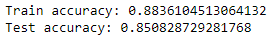

default:
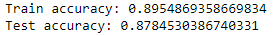


The training accuracy for the RFE model is slightly higher than the test accuracy which indicates slight overfitting.

The top 5 features were:
- Neutrophils
- Proteina C Reativa mg/dL
- Patient age quantile 
- Mean platelet volume
- monocytes

### ROC curve comparison

In [22]:
y_pred_proba_lr = model.predict_proba(X_test)
y_pred_proba_lr_cv = cv.predict_proba(X_test)
y_pred_proba_rfe_cv = rfe_cv.predict_proba(X_test_sel)


roc_index_lr = roc_auc_score(y_test, y_pred_proba_lr[:, 1])
roc_index_lr_cv = roc_auc_score(y_test, y_pred_proba_lr_cv[:, 1])
roc_index_rfe_cv = roc_auc_score(y_test, y_pred_proba_rfe_cv[:, 1])

print("ROC index on test for `model`:", roc_index_lr)
print("ROC index on test for `cv`:", roc_index_lr_cv)
print("ROC index on test for `rfe_cv`:", roc_index_rfe_cv)

ROC index on test for `model`: 0.8197435897435897
ROC index on test for `cv`: 0.8048717948717948
ROC index on test for `rfe_cv`: 0.7858974358974359


In [23]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr[:,1])
fpr_lr_cv, tpr_lr_cv, thresholds_lr_cv = roc_curve(y_test, y_pred_proba_lr_cv[:,1])
fpr_rfe_cv, tpr_rfe_cv, thresholds_rfe_cv = roc_curve(y_test, y_pred_proba_rfe_cv[:,1])

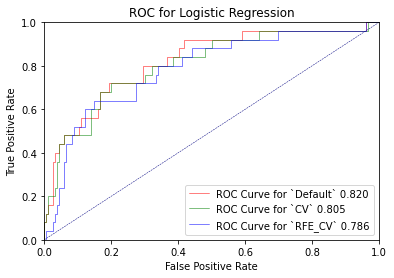

In [24]:
plt.plot(fpr_lr, tpr_lr, label='ROC Curve for `Default` {:.3f}'.format(roc_index_lr), color='red', lw=0.5)
plt.plot(fpr_lr_cv, tpr_lr_cv, label='ROC Curve for `CV` {:.3f}'.format(roc_index_lr_cv), color='green', lw=0.5)
plt.plot(fpr_rfe_cv, tpr_rfe_cv, label='ROC Curve for `RFE_CV` {:.3f}'.format(roc_index_rfe_cv), color='blue', lw=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Logistic Regression')
plt.legend(loc="lower right")
plt.show()

In [25]:
from sklearn import metrics
matrix = metrics.confusion_matrix(y_test, y_pred)

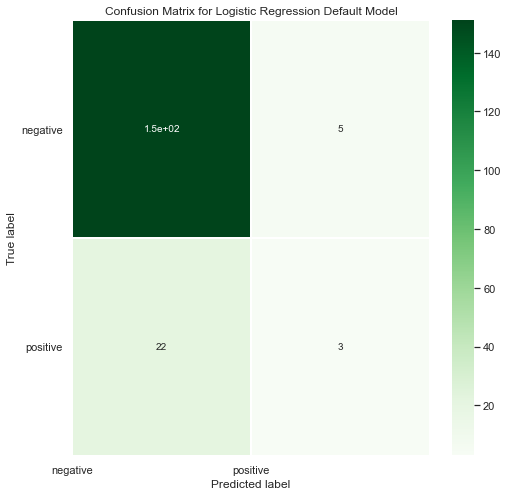

In [26]:
# counts
# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.5)

# Add labels to the plot
class_names = ['negative', 'positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression Default Model')

plt.show()

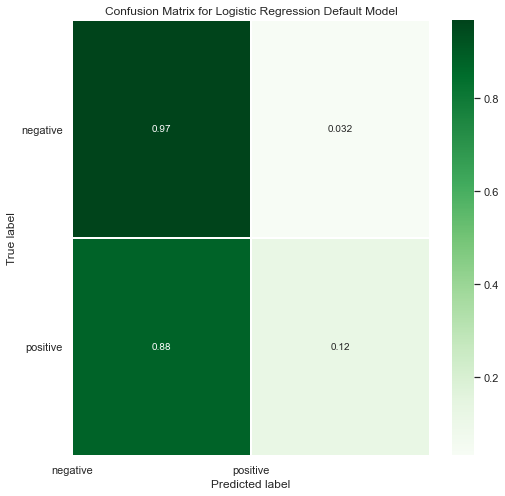

In [27]:
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(8,8))
sns.set(font_scale=1)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.5)

# Add labels to the plot
class_names = ['negative', 'positive']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Logistic Regression Default Model')

plt.show()

Using ROC curve identifies that the best model for predicting COVID-19 patients is the default logistic model.

The test accuracy of this model is 89%, however, when looking at the dataset, only 3 patients that have tested positive for COVID-19 have been accurately predicted. This suggests that this model may not correctly predict patients with COVID-19.

It is hard to correctly predict the general characteristics of patients with COVID-19 as this model is heavily skewed to predicting patients with negative test results. The features of greatest importance for the default model are levels of Leukocytes, Eosinophils, Platelets, and Hematocrits levels, and Influenza B Rapid Test results.

In [28]:
import pickle
lr_best = model
roc_index_lr_best = roc_index_lr
tpr_lr_best = tpr_lr
fpr_lr_best = fpr_lr
with open('Best_LR.pickle', 'wb') as f:
    pickle.dump([lr_best,roc_index_lr_best, fpr_lr_best, tpr_lr_best], f)